In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.linalg
import scipy.interpolate
import scipy.stats

In [3]:
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord,EarthLocation,AltAz,ICRS
from astropy.wcs import WCS

In [4]:
import galsim

In [5]:
import json

In [38]:
mpl.rcParams.update({'font.size': 18})
mpl.rcParams.update({'savefig.dpi': 100})
mpl.rcParams.update({'savefig.bbox': 'tight'})

In [6]:
class Telescope(object):
    """
    Represents a telescope.
    """
    def __init__(self,diameter=3.80*u.m,obscuration_area_fraction=0.25,throughput=0.95*0.77,plate_scale=67.40*u.um/u.arcsec):
        self.diameter = diameter
        self.obscuration_area_fraction = obscuration_area_fraction
        self.throughput = throughput
        self.plate_scale = plate_scale
        self.effective_area = np.pi*diameter**2/4.*(1-obscuration_area_fraction)
    def get_optical_psf(self,wavelength):
        #Convert dimensionless lam/D to arcsec units.
        lam_over_diam_arcsec = ((wavelength/self.diameter)*u.rad).to(u.arcsec)
        # Airy requires floats as inputs, not numpy scalars.
        return galsim.Airy(lam_over_diam=float(lam_over_diam_arcsec.value),
            obscuration=float(np.sqrt(self.obscuration_area_fraction)))
    def get_atmospheric_psf(self,wavelength,fwhm5400, gauss=False):
        wlen_ratio = (wavelength/(5400*u.Angstrom)).si
        assert wlen_ratio == wlen_ratio.value,'wavelength has invalid units.'
        fwhm = fwhm5400.to(u.arcsec).value*wlen_ratio**(-0.2)
        # Kolmogorov requires floats as inputs, not numpy scalars.
        if gauss:
            return galsim.Gaussian(fwhm=float(fwhm))
        else:
            return galsim.Kolmogorov(fwhm=float(fwhm))
    def get_psf(self,wavelength,fwhm5400,rms_jitter=0.1*u.arcsec, gauss=False):
        components = [ self.get_atmospheric_psf(wavelength,fwhm5400,gauss=gauss),self.get_optical_psf(wavelength) ]
        # Include a Gaussian pointing jitter, if requested.
        if rms_jitter is not None:
            components.append(galsim.Gaussian(sigma = rms_jitter.to(u.arcsec).value))
        return galsim.Convolve(components)

In [7]:
def calculate_fiber_acceptance(fiber_diameter,psf,sampling=100,max_offset=2):
    """
    Calculate the fiber acceptance fraction versus offset for a specified PSF.
    
    Args:
        fiber_diameter: Diameter of the fiber to use with explicit angular units.
        psf: PSF model to use, assumed to be specified in arcseconds.
        sampling: Sampling to use for the calculation. Higher samplings take longer
            but give more accurate results.
        max_offset: Maximum centroid offset to calculate, as a ratio of the
            fiber diameter.
    
    Returns:
        tuple: Tuple (offset,acceptance) where offset is given as a ratio of fiber
            diameter and acceptance is a fraction from 0-1.
    """
    # Render the PSF to an image with size fiber_diameter by (max_offset+1)*fiber_diameter.
    diam_arcsec = (fiber_diameter.to(u.arcsec)).value
    width = 2*sampling+1
    height = int(np.ceil((max_offset+1)*width))
    image = galsim.Image(width,height,scale=diam_arcsec/width)
    psf.shift(dx=0.,dy=-0.5*diam_arcsec*max_offset).drawImage(image=image)
    # Prepare a boolean mask of pixels falling inside the fiber aperture.
    xy = np.arange(width) - 0.5*(width-1)
    x,y = np.meshgrid(xy,xy)
    mask = (x**2 + y**2 < (0.5*width)**2)
    # Loop over centroid offsets.
    offset = np.arange(height-width+1)/float(width)
    acceptance = np.empty_like(offset)
    for dy in range(height-width):
        acceptance[dy] = np.sum(image.array[dy:dy+width]*mask)
    return offset,acceptance

In [8]:
t_sdss = Telescope(diameter=2.5*u.m, obscuration_area_fraction=0.27, plate_scale=217.7358*u.mm/u.deg)

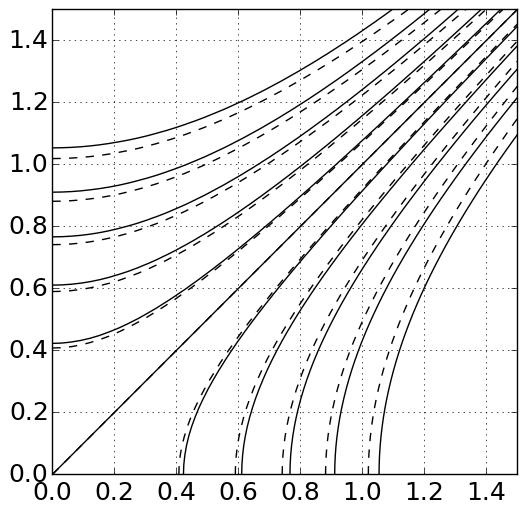

In [41]:
def plot_offset_acceptance_contours(t, D=2*u.arcsec, wlen=5400*u.Angstrom, fwhm=1.5, sampling=100):
    plt.figure(figsize=(8,6))

    plt.subplot(1,1,1, aspect='equal')

    psf = t.get_atmospheric_psf(wlen,fwhm*u.arcsec)
    offsets, A = calculate_fiber_acceptance(D,psf)
    A_interp = scipy.interpolate.interp1d(offsets*D.to(u.arcsec).value,A)
            
    gauss_psf = t.get_atmospheric_psf(wlen,fwhm*u.arcsec,gauss=True)
    offsets, A_gauss = calculate_fiber_acceptance(D,gauss_psf)
    A_gauss_interp = scipy.interpolate.interp1d(offsets*D.to(u.arcsec).value, A_gauss)
    
    d = np.linspace(0,1.5,50)
    x,y = np.meshgrid(d,d)
    
    C = A_interp(x)/A_interp(y)
    C_gauss = A_gauss_interp(x)/A_gauss_interp(y)
    
    frac_levels = np.linspace(.5,.9,5).tolist()
    levels = frac_levels + [1] + [1.0/l for l in frac_levels[::-1]]
        
    contours = plt.contour(x, y, C, levels, colors='k')
    contours = plt.contour(x, y, C_gauss, levels, colors='k', linestyles ='dashed')

plot_offset_acceptance_contours(t_sdss)
plt.grid()

In [10]:
data = np.loadtxt('/Users/daniel/source/blupe/work/tpcorr_ref/temp-ref-all.txt', ndmin=2)

In [11]:
platescale = 217.7358 # mm/deg
mm_to_arcsec = 3600/platescale

# the first few columns are fiber/obs meta data, the rest are calculated offsets and acceptance fractions
nidtokens = 8

psf_fwhm = data[:, 0]
plate = data[:, 1]
mjd = data[:, 2]
fiberid = data[:, 3]
xfocal = data[:, 4]
yfocal = data[:, 5]
xfocal_5400 = data[:, 6]
yfocal_5400 = data[:, 7]

# the rest are the tabulated throughput correction values
npoints = 71
nfields = 3

# the throughput correction vectors span the range 3500A to 10500A
waves_data = np.linspace(3500, 10500, npoints, endpoint=True)
dx = data[:, nidtokens+0::nfields]
dy = data[:, nidtokens+1::nfields]
tpcorr = data[:, nidtokens+2::nfields]

In [12]:
xhole_offset = mm_to_arcsec*(xfocal-xfocal_5400)
yhole_offset = mm_to_arcsec*(yfocal-yfocal_5400)

In [13]:
d4000_all = np.sqrt(dx**2 + dy**2)
d5400_all = np.sqrt((dx + xhole_offset.reshape(-1,1))**2 + (dy + yhole_offset.reshape(-1,1))**2)

<matplotlib.colorbar.Colorbar instance at 0x1feabe680>

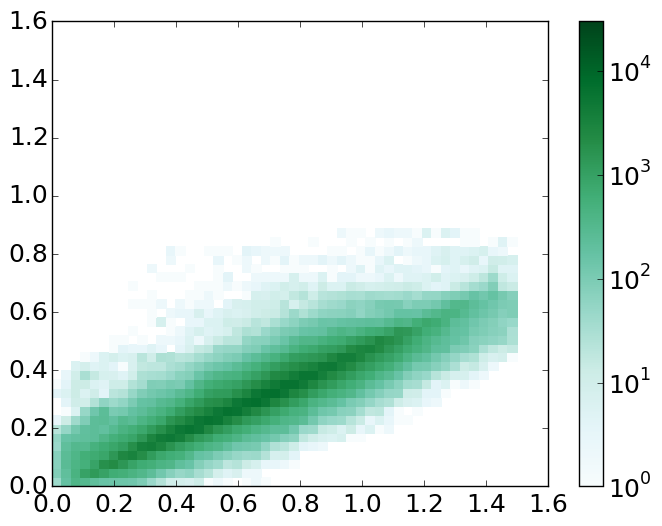

In [15]:
plt.figure(figsize=(8,6))
# estimate the 2D histogram
H, xedges, yedges = np.histogram2d(d4000_all[:,-1], d5400_all[:,-1], bins=np.linspace(0,1.5,50))

# H needs to be rotated and flipped
H = np.rot90(H)
H = np.flipud(H)      

# plot 2D histogram using pcolor
# explore different color map options http://matplotlib.org/users/colormaps.html
plt.pcolormesh(xedges, yedges, H, cmap=plt.get_cmap('BuGn'), norm=mpl.colors.LogNorm(), vmin=1, vmax=3*10**4)
plt.colorbar()

In [115]:
def plot_dx_scatter(ilambda, dmin=0, dmax=1.5, nd=50, cmap_name='Blues',
                    t=t_sdss, D=2*u.arcsec, wlen=5400*u.Angstrom, fwhm=1.5, save=False, 
                    vary_fwhm=False, vary_psf_wave=True, atmos_only=True, gauss=False):
        
    edges = np.linspace(dmin, dmax, nd+1)
    
    wave = waves_data[ilambda]

    dx_wave = dx[:,ilambda]
    dy_wave = dy[:,ilambda]

    d4000 = np.sqrt(dx_wave**2 + dy_wave**2)
    d5400 = np.sqrt((dx_wave + xhole_offset)**2 + (dy_wave + yhole_offset)**2)

    # estimate the 2D histogram
    H, xedges, yedges = np.histogram2d(d4000, d5400, bins=edges)

    # H needs to be rotated and flipped
    H = np.rot90(H)
    H = np.flipud(H)      

    # plot 2D histogram using pcolor
    # explore different color map options http://matplotlib.org/users/colormaps.html
    plt.pcolormesh(xedges, yedges, H, cmap=plt.get_cmap(cmap_name), norm=mpl.colors.LogNorm(), vmin=1, vmax=3*10**4, rasterized=True)
    cbar = plt.colorbar()
    cbar.solids.set_rasterized(True)
    cbar.solids.set_edgecolor("face")
    
    if vary_fwhm:
        fwhms = [1.2, 1.5, 1.8]
        linestyles = ['-.', 'solid', 'dashed']
        
        for i in range(len(fwhms)):
            
            if vary_psf_wave:
                psf_wave = wave*u.Angstrom
            else:
                psf_wave = wlen
            
            if atmos_only:
                psf = t.get_atmospheric_psf(psf_wave,fwhms[i]*u.arcsec, gauss=gauss)
            else:
                psf = t.get_psf(psf_wave,fwhms[i]*u.arcsec)
            offsets, A = calculate_fiber_acceptance(D,psf)
            A_interp = scipy.interpolate.interp1d(offsets*D.to(u.arcsec).value,A)                

            d = np.linspace(dmin, dmax, nd)
            x,y = np.meshgrid(d,d)

            C = A_interp(y)/A_interp(x)
            
            ratio_frac_levels = np.linspace(.5,.9,3).tolist()
            ratio_levels = ratio_frac_levels + [1.0/l for l in ratio_frac_levels[::-1]]
            contours_ratio = plt.contour(x, y, C, ratio_frac_levels, colors='green', linewidths=1, linestyles=linestyles[i])
#             if i == 1:  plt.clabel(contours_ratio, fontsize=11, fmt=lambda l: '%.2f'%l)
            contours_ratio = plt.contour(x, y, C, [1.0/l for l in ratio_frac_levels[::-1]], colors='green', linewidths=1, linestyles=linestyles[i])
#             if i == 1:  plt.clabel(contours_ratio, fontsize=11, fmt=lambda l: '%.2f'%l) 
                
            if i == 1:
                psf0 = t.get_atmospheric_psf(wave*u.Angstrom, fwhms[i]*u.arcsec)
                offsets0, A0 = calculate_fiber_acceptance(D, psf0)
                A_interp0 = scipy.interpolate.interp1d(offsets0*D.to(u.arcsec).value, A0)
                C0 = A_interp0(y)/A_interp0(x)
                contours_ratio = plt.contour(x, y, C0, ratio_frac_levels, colors='black', linewidths=1, linestyles=linestyles[i])
                plt.clabel(contours_ratio, fontsize=11, fmt=lambda l: '%.2f'%l)
                contours_ratio = plt.contour(x, y, C0, [1.0/l for l in ratio_frac_levels[::-1]], colors='black', linewidths=1, linestyles=linestyles[i])
                plt.clabel(contours_ratio, fontsize=11, fmt=lambda l: '%.2f'%l)
      
    else:
        psf = t.get_atmospheric_psf(wlen,fwhm*u.arcsec)
        offsets, A = calculate_fiber_acceptance(D,psf)
        A_interp = scipy.interpolate.interp1d(offsets*D.to(u.arcsec).value,A)

        gauss_psf = t.get_atmospheric_psf(wlen,fwhm*u.arcsec,gauss=True)
        offsets, A_gauss = calculate_fiber_acceptance(D,gauss_psf)
        A_gauss_interp = scipy.interpolate.interp1d(offsets*D.to(u.arcsec).value, A_gauss)

        d = np.linspace(dmin, dmax, nd)
        x,y = np.meshgrid(d,d)
        
        C = A_interp(y)/A_interp(x)
        C_gauss = A_gauss_interp(y)/A_gauss_interp(x)
            
        frac_levels = np.linspace(.5,.9,5).tolist()
        levels = frac_levels + [1] + [1.0/l for l in frac_levels[::-1]]

        contours = plt.contour(x, y, C, frac_levels, colors='b', linewidths=.7, linestyles ='dotted')
        plt.clabel(contours, fontsize=11, fmt=lambda l: '%.2f'%l)
        contours = plt.contour(x, y, C, [1.0/l for l in frac_levels[::-1]], colors='r', linewidths=.7, linestyles ='dotted')
        plt.clabel(contours, fontsize=11, fmt=lambda l: '%.2f'%l)
        contours_gauss = plt.contour(x, y, C_gauss, frac_levels, colors='b', linewidths=.7, linestyles ='dashed')
    #     plt.clabel(contours_gauss, fontsize=11, fmt=lambda l: '   ')
        contours_gauss = plt.contour(x, y, C_gauss, [1.0/l for l in frac_levels[::-1]], colors='r', linewidths=.7, linestyles ='dashed')
    #     plt.clabel(contours_gauss, fontsize=11, fmt=lambda l: '   ')
    plt.plot(d,d, color='green', ls='-', lw=1)
        
    plt.gca().set_aspect('equal')
    plt.xlabel(r'$d_i^\ast(\lambda,\lambda_i,h_\mathrm{obs})$ $(\mathrm{arcseconds})$')
    plt.ylabel(r'$d_i^\ast(\lambda,\lambda_c,h_\mathrm{obs})$ $(\mathrm{arcseconds})$')
    plt.ylim(dmin, dmax)
    plt.title(r'$\lambda$ = %d $\AA$' % wave)
    plt.xlim(dmin, dmax)
    plt.tight_layout()
    if save:
        plt.savefig('/Users/daniel/source/blupe/work/tpcorr_ref/offset-compare-%05d.png' % wave)

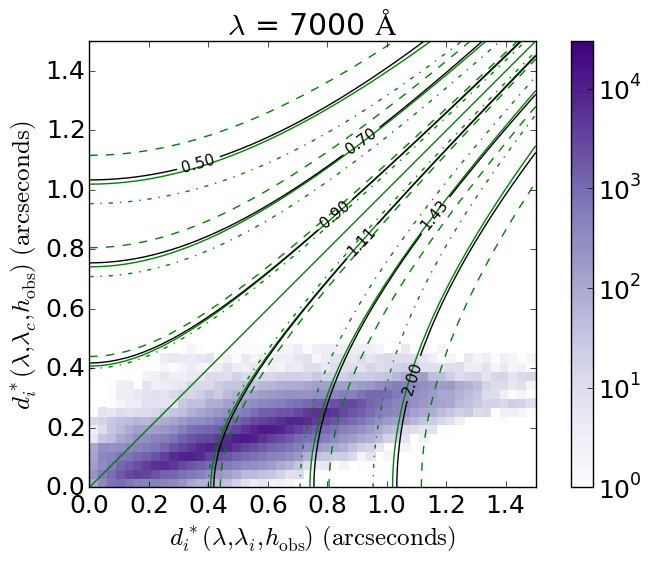

In [116]:
fig = plt.figure(figsize=(8,6))
plot_dx_scatter(35, cmap_name='Purples', fwhm=1.5, vary_fwhm=True, vary_psf_wave=False, atmos_only=True, gauss=True)

In [56]:
for i in range(len(waves_data)):
    fig = plt.figure(figsize=(8,6))
    plot_dx_scatter(i, cmap_name='BuGn', vary_fwhm=True, vary_psf_wave=False, save=True, atmos_only=True, gauss=True)
    plt.close()

In [65]:
[waves_data[1], waves_data[5], waves_data[10], waves_data[19], waves_data[35], waves_data[65]]

[3600.0, 4000.0, 4500.0, 5400.0, 7000.0, 10000.0]

In [117]:
def plot_offset_scatter(ilambda, dmin=0, dmax=1.5, nd=50, cmap_name='Blues',
    t=t_sdss, D=2*u.arcsec, wlen=5400*u.Angstrom, fwhm=1.5, save=False):
        
    edges = np.linspace(dmin, dmax, nd+1)
    
    wave = waves_data[ilambda]

    dx_wave = dx[:,ilambda]
    dy_wave = dy[:,ilambda]

    d4000 = np.sqrt(dx_wave**2 + dy_wave**2)
    d5400 = np.sqrt((dx_wave + xhole_offset)**2 + (dy_wave + yhole_offset)**2)

    # estimate the 2D histogram
    H, xedges, yedges = np.histogram2d(d4000, d5400, bins=edges)

    # H needs to be rotated and flipped
    H = np.rot90(H)
    H = np.flipud(H)      

    # plot 2D histogram using pcolor
    # explore different color map options http://matplotlib.org/users/colormaps.html
    plt.pcolormesh(xedges, yedges, H, cmap=plt.get_cmap(cmap_name), norm=mpl.colors.LogNorm(), vmin=1, vmax=3*10**4, rasterized=True)
    cbar = plt.colorbar()
    cbar.solids.set_rasterized(True)
    cbar.solids.set_edgecolor("face")
    
    psf = t.get_atmospheric_psf(wave*u.Angstrom,fwhm*u.arcsec)
    offsets, A = calculate_fiber_acceptance(D,psf)
    A_interp = scipy.interpolate.interp1d(offsets*D.to(u.arcsec).value,A)

    gauss_psf = t.get_atmospheric_psf(wlen,fwhm*u.arcsec,gauss=True)
    offsets, A_gauss = calculate_fiber_acceptance(D,gauss_psf)
    A_gauss_interp = scipy.interpolate.interp1d(offsets*D.to(u.arcsec).value, A_gauss)

    d = np.linspace(dmin, dmax, nd)
    x,y = np.meshgrid(d,d)

    C = A_interp(y)/A_interp(x)
    C_gauss = A_gauss_interp(y)/A_gauss_interp(x)

    frac_levels = np.linspace(.5,.9,5).tolist()
    levels = frac_levels + [1] + [1.0/l for l in frac_levels[::-1]]

    contours = plt.contour(x, y, C, frac_levels, colors='k', linewidths=1, linestyles ='solid')
    plt.clabel(contours, fontsize=11, fmt=lambda l: '%.2f'%l)
    contours = plt.contour(x, y, C, [1.0/l for l in frac_levels[::-1]], colors='k', linewidths=1, linestyles ='solid')
    plt.clabel(contours, fontsize=11, fmt=lambda l: '%.2f'%l)
    contours_gauss = plt.contour(x, y, C_gauss, frac_levels, colors='green', linewidths=1, linestyles ='solid')
    #     plt.clabel(contours_gauss, fontsize=11, fmt=lambda l: '   ')
    contours_gauss = plt.contour(x, y, C_gauss, [1.0/l for l in frac_levels[::-1]], colors='green', linewidths=1, linestyles ='solid')
    #     plt.clabel(contours_gauss, fontsize=11, fmt=lambda l: '   ')
    plt.plot(d,d, color='k', ls='-', lw=1)
        
    plt.gca().set_aspect('equal')
    plt.xlabel(r'$d_i^\ast(\lambda,\lambda_i,h_\mathrm{obs})$ $(\mathrm{arcseconds})$')
    plt.ylabel(r'$d_i^\ast(\lambda,\lambda_c,h_\mathrm{obs})$ $(\mathrm{arcseconds})$')
    plt.ylim(dmin, dmax)
    plt.title(r'$\lambda$ = %d $\AA$' % wave)
    plt.xlim(dmin, dmax)
    plt.tight_layout()
    if save:
        plt.savefig('/Users/daniel/source/blupe/work/tpcorr_ref/offset-compare-%05d.png' % wave)

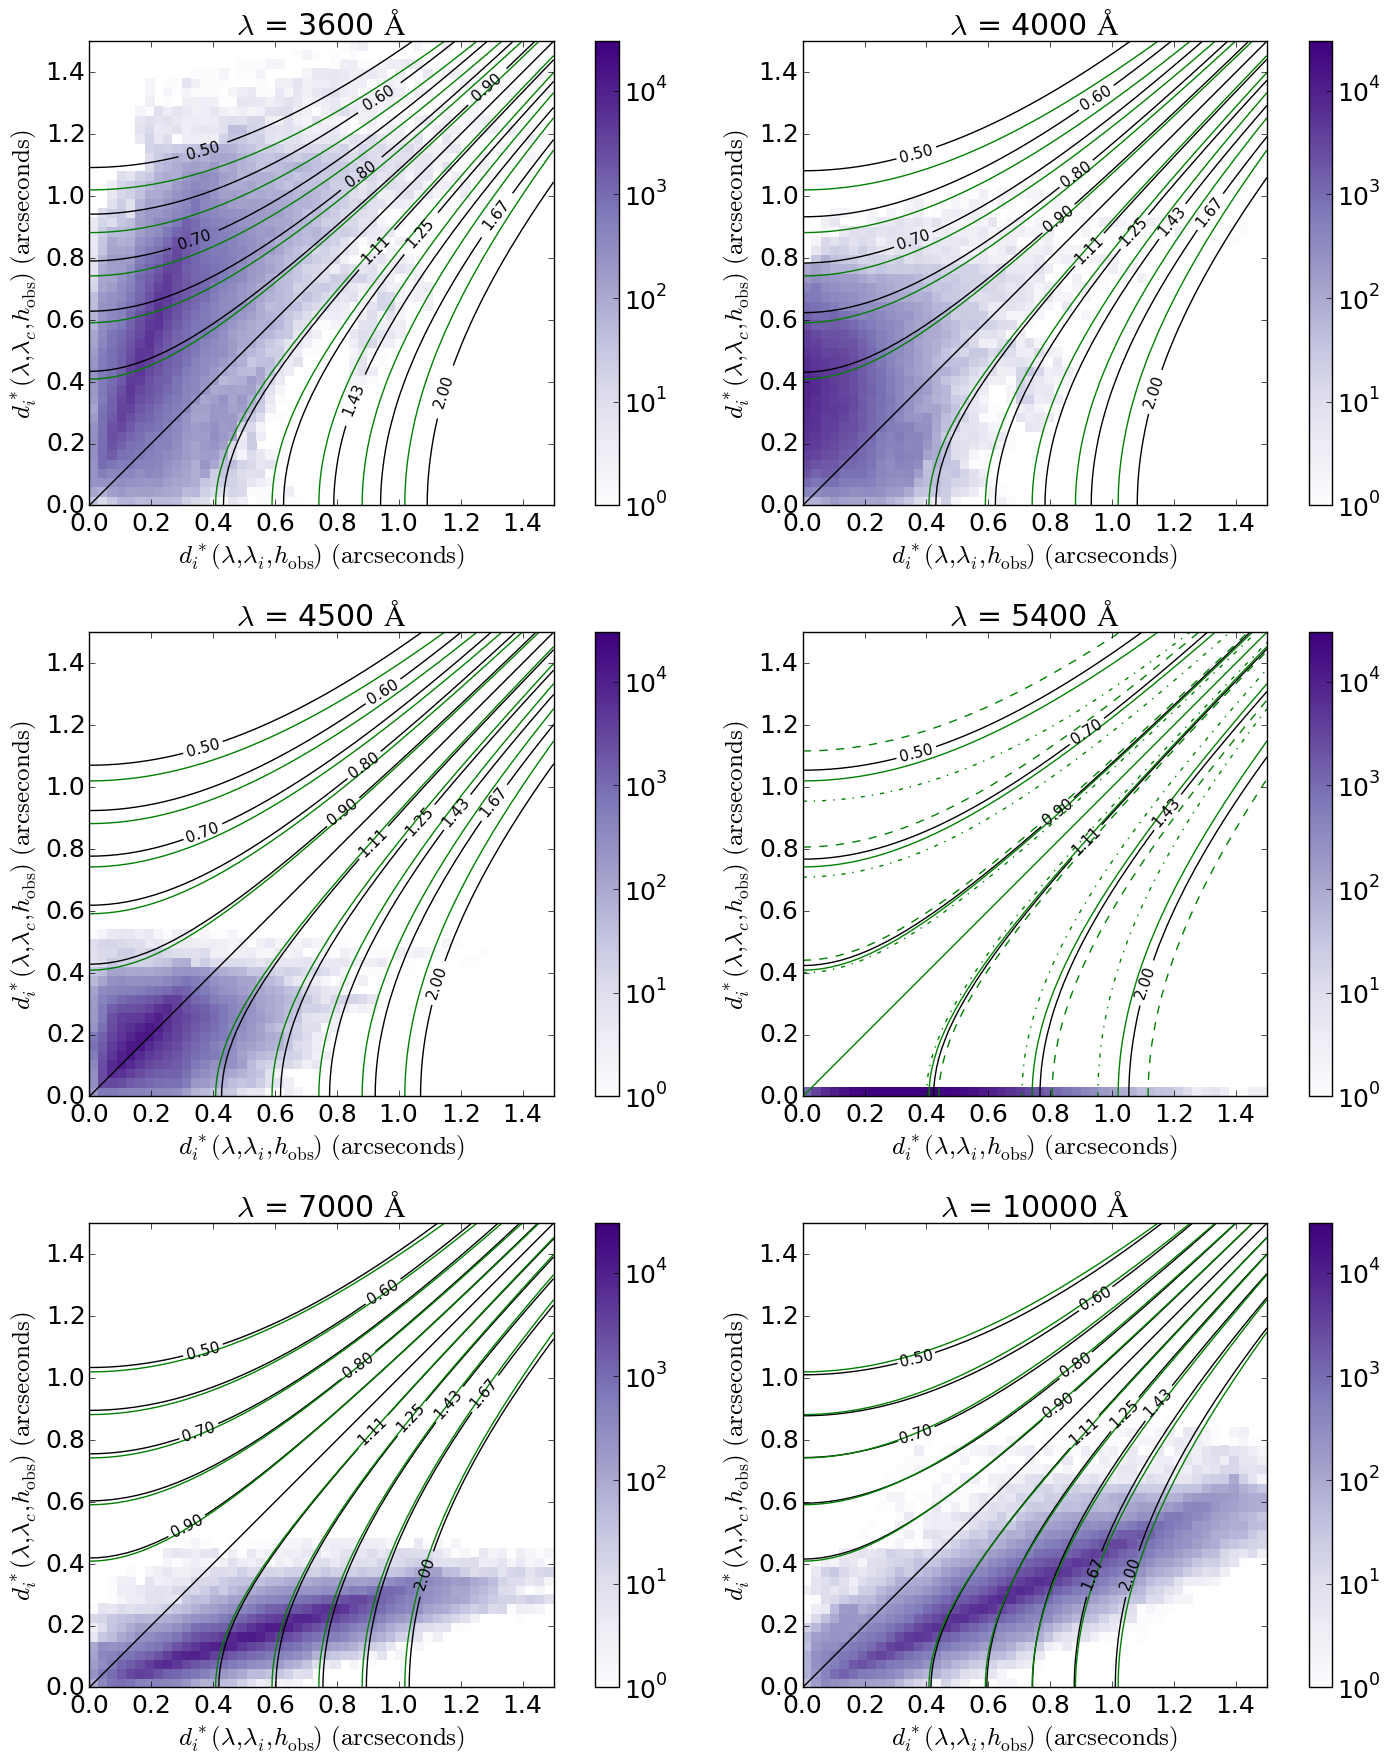

In [118]:
fig, axes = plt.subplots(3, 2, figsize=(16,18))
for i, iwave in enumerate([1,5,10,19,35,65]):
    plt.sca(axes[i//2,i%2])
    if i == 3:
        plot_dx_scatter(iwave, cmap_name='Purples', vary_fwhm=True, vary_psf_wave=False, save=True, atmos_only=True, gauss=True)
    else:
        plot_offset_scatter(iwave, cmap_name='Purples', save=False)
plt.tight_layout()
plt.savefig('/Users/daniel/source/blupe/paper_plots/offset-compare-montage.pdf', bbox_inches='tight', dpi=200)

In [124]:
def calculate_correction(i, t=t_sdss, wlen=5400*u.Angstrom, D=2*u.arcsec, sampling=100, gauss=False):
    psf = t.get_atmospheric_psf(wlen, psf_fwhm[i]*u.arcsec, gauss=gauss)
    offset_fractions, A = calculate_fiber_acceptance(D, psf, sampling=sampling)
    # convert offset fractions to absolute values in arcsec
    offsets = offset_fractions*D.to(u.arcsec).value
    A_interp = scipy.interpolate.interp1d(offsets, A, kind='linear')
    C_i = A_interp(d5400_all[i])/A_interp(d4000_all[i])
    return C_i

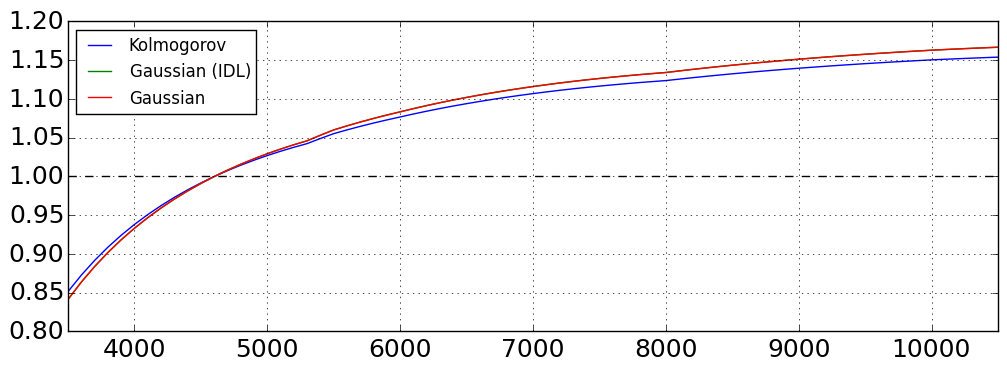

In [128]:
fig = plt.figure(figsize(12,4))

itarget = 35000
plt.plot(waves_data, calculate_correction(itarget), color='blue', label='Kolmogorov')
plt.plot(waves_data, tpcorr[itarget], color='green', label='Gaussian (IDL)')
plt.plot(waves_data, calculate_correction(itarget, gauss=True), color='red', label='Gaussian')

plt.xlim(waves_data[0], waves_data[-1])
# plt.ylim(.5,1.9)
plt.legend(loc=2, fontsize=12)
plt.grid()
plt.axhline(1, ls='--', c='k')
plt.show()

In [23]:
calculate_correction(itarget)

array([ 0.72217767,  0.75621881,  0.78796463,  0.81753694,  0.84512465,
        0.87092045,  0.89509555,  0.91780219,  0.93916984,  0.95936825,
        0.97847241,  0.99656983,  1.01379023,  1.03014463,  1.04572977,
        1.06060919,  1.07480812,  1.08838257,  1.10136938,  1.11375393,
        1.12559178,  1.13750917,  1.14898109,  1.16003336,  1.17066978,
        1.18093604,  1.19020229,  1.19909879,  1.20765796,  1.21589808,
        1.22381894,  1.23144758,  1.23879636,  1.24587426,  1.25269708,
        1.25927318,  1.26561523,  1.27173114,  1.2776348 ,  1.28333575,
        1.28883897,  1.29415632,  1.29928541,  1.30424861,  1.30905157,
        1.31368429,  1.31829653,  1.32277361,  1.32709011,  1.33129269,
        1.33535829,  1.33930367,  1.34313428,  1.34684778,  1.35045454,
        1.3539562 ,  1.35735975,  1.36066874,  1.36387309,  1.36700512,
        1.37003079,  1.37298253,  1.37585978,  1.37864569,  1.38137041,
        1.384018  ,  1.38644769,  1.38881916,  1.39112226,  1.39

In [16]:
sigmas = [100*scipy.stats.norm.cdf(sigma) for sigma in [-2,-1, 0, 1, 2]]

In [65]:
tpcorr_mean = np.mean(tpcorr, axis=0)
tpcorr_levels = [np.percentile(tpcorr, p, axis=0) for p in sigmas]

In [63]:
tpcorr_kolm = np.empty_like(tpcorr)
for i in range(tpcorr_kolm.shape[0]):
    tpcorr_kolm[i] = calculate_correction2(a2d, i).flatten()
kolm_mean = np.mean(tpcorr_kolm, axis=0)
kolm_levels = [np.percentile(tpcorr_kolm, p, axis=0) for p in sigmas]

In [69]:
tpcorr_gauss = np.empty_like(tpcorr)
for i in range(tpcorr_gauss.shape[0]):
    tpcorr_gauss[i] = calculate_correction2(a2dgauss, i).flatten()
gauss_mean = np.mean(tpcorr_gauss, axis=0)
gauss_levels = [np.percentile(tpcorr_gauss, p, axis=0) for p in sigmas]

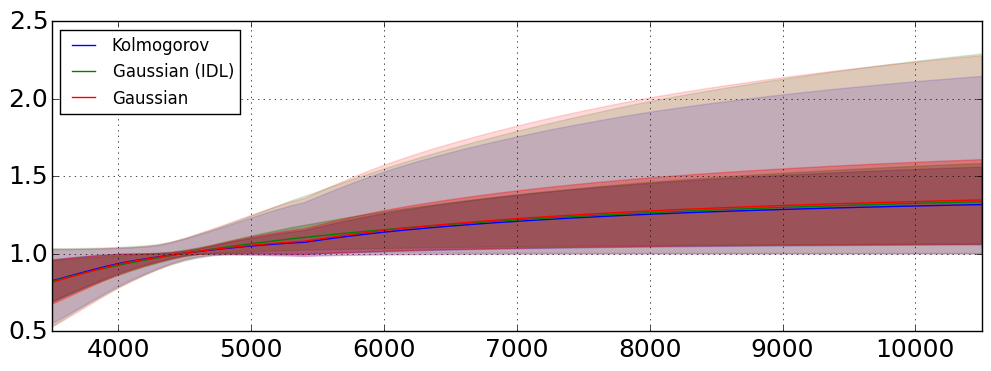

In [73]:
fig = plt.figure(figsize(12,4))

plt.fill_between(waves_data, kolm_levels[0], kolm_levels[4], color='blue', alpha=.15)
plt.fill_between(waves_data, kolm_levels[1], kolm_levels[3], color='blue', alpha=.3)
plt.plot(waves_data, kolm_mean, color='blue', label='Kolmogorov')

plt.fill_between(waves_data, tpcorr_levels[0], tpcorr_levels[4], color='green', alpha=.15)
plt.fill_between(waves_data, tpcorr_levels[1], tpcorr_levels[3], color='green', alpha=.3)
plt.plot(waves_data, tpcorr_mean, color='green', label='Gaussian (IDL)')

plt.fill_between(waves_data, gauss_levels[0], gauss_levels[4], color='red', alpha=.15)
plt.fill_between(waves_data, gauss_levels[1], gauss_levels[3], color='red', alpha=.3)
plt.plot(waves_data, gauss_mean, color='red', label='Gaussian')

# itarget = 25000
# plt.plot(waves_data, tpcorr[itarget], label='IDL')
# plt.plot(waves_data, calculate_correction(itarget), label='Galsim (Kolm)')
# plt.plot(waves_data, calculate_correction(itarget, gauss=True), label='Galsim (Gauss)')

plt.xlim(waves_data[0], waves_data[-1])
plt.ylim(.5,2.5)
plt.legend(loc=2, fontsize=12)
plt.grid()
# plt.axhline(1, ls='--', c='k')
plt.show()

In [18]:
def correction_interpolator(t=t_sdss, wlen=5400*u.Angstrom, D=2*u.arcsec, sampling=100, gauss=False):
    psf_grid = np.linspace(1, 2.6, sampling)
    
    As = []
    
    for fwhm in psf_grid:
        psf = t.get_atmospheric_psf(wlen, fwhm*u.arcsec, gauss=gauss)
        offset_fractions, A = calculate_fiber_acceptance(D, psf, sampling=sampling)
        # convert offset fractions to absolute values in arcsec
        offsets = offset_fractions*D.to(u.arcsec).value
        As.append(A)
            
    return offsets, psf_grid, As

In [26]:
offs,psf_grid,As = correction_interpolator()
offs2d, psf_grid2d = np.meshgrid(offs, psf_grid)
a2d = scipy.interpolate.SmoothBivariateSpline(offs2d.flatten(), psf_grid2d.flatten(), np.array(As).flatten(), kx=1, ky=1, s=3)

In [20]:
offs,psf_grid,As = correction_interpolator(gauss=True)
offs2d, psf_grid2d = np.meshgrid(offs, psf_grid)
a2dgauss = scipy.interpolate.SmoothBivariateSpline(offs2d.flatten(), psf_grid2d.flatten(), np.array(As).flatten(), kx=5, ky=5, s=3)

In [21]:
def calculate_correction2(a2d, i):
    itarget = i
    wtmp = waves_data[np.argsort(d5400_all[itarget])]
    atmp = a2d(np.sort(d5400_all[itarget]), psf_fwhm[itarget])
    wtmp2 = waves_data[np.argsort(d4000_all[itarget])]
    atmp2 = a2d(np.sort(d4000_all[itarget]), psf_fwhm[itarget])
    return atmp[np.argsort(wtmp)]/atmp2[np.argsort(wtmp2)]

In [30]:
d4000_all[itarget]

array([ 0.4204366 ,  0.33830355,  0.26386125,  0.19659965,  0.13666671,
        0.08623966,  0.05595729,  0.06575057,  0.09930179,  0.1371779 ,
        0.17448984,  0.21010764,  0.24376506,  0.27547282,  0.30529186,
        0.33335677,  0.35977597,  0.38466125,  0.40813508,  0.43015211,
        0.45094305,  0.47158592,  0.49118025,  0.50980253,  0.52751498,
        0.5443776 ,  0.55938924,  0.5736677 ,  0.58724344,  0.60017328,
        0.61249186,  0.62423909,  0.63544981,  0.646152  ,  0.65638155,
        0.66616253,  0.67552289,  0.68448261,  0.69306874,  0.70130127,
        0.70919228,  0.71677083,  0.72404794,  0.73103861,  0.73775588,
        0.74422086,  0.75061644,  0.75678093,  0.76272134,  0.76845571,
        0.77399108,  0.77933041,  0.78449582,  0.7894813 ,  0.79430492,
        0.79896761,  0.80348757,  0.80785566,  0.81208699,  0.81618652,
        0.82015944,  0.82400859,  0.82774607,  0.83136788,  0.83488413,
        0.83829974,  0.84142524,  0.84445616,  0.84739448,  0.85

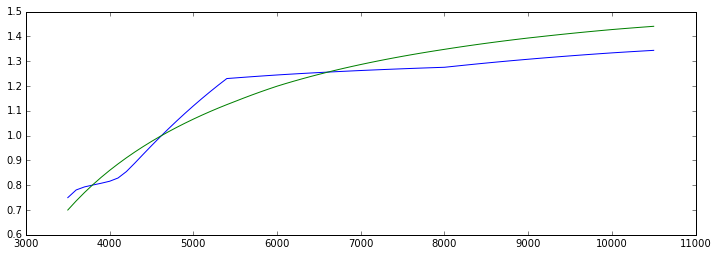

In [31]:
plt.plot(waves_data, calculate_correction2(a2d, 0))
plt.plot(waves_data, tpcorr[itarget])
plt.show()

In [ ]:
a2d(np.sort(d5400_all[itarget]), 1.5*np.ones(71)).diagonal()

In [96]:
a2d([.5], [1.2, 1.5])

array([[ 0.62801698,  0.51897359]])